# AGH - Deep Learning in Medical Image Analysis I

Author: Marek Wodziński

Contact: wodzinski@agh.edu.pl

You are allowed to use these materials for all purposes as long as the credit is given.


# Laboratory 3 - Datasets, Dataloaders

The goal of the Laboratory 3 is to:
<ul>
  <li> Get familiar with loading images using various I/O libraries.
  <li> Implement several datasets/dataloaders in PyTorch.
  <li> Understand the parameters and limitations of PyTorch dataloaders.
</ul>

You are going to start with simple built-in datasets in torchvision to get familiar with the loading hyperparameters. Then, you will implement three datasets/dataloaders using real medical images.

### Part I - Basic Dataloaders

You are going to start with build-in dataset available in **torchvision** - a library dedicated computer vision in PyTorch. It contains several frequently used datasets for prototyping, like MNIST, CIFAR10 and others. You can check the list of available dataset under the following link:

https://pytorch.org/vision/stable/datasets.html

During this laboratory you will use the MNIST dataset.

It is recommended to read:
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html before continuing.

Let's start with creating the Dataset object: 


In [1]:
import numpy as np
import torch as tc
import pandas as pd
import matplotlib.pyplot as plt
import torchvision as tv
import os
import SimpleITK as sitk

download = True # Set to True only during the first run or after reseting the notebook, then set to False
train = False # Let's use the testing dataset
root = '/content/MNIST' # Let's download the dataset to the /content folder
transform = tv.transforms.ToTensor() # Used to convert the PIL image to PyTorch Tensor
mnist_dataset = tv.datasets.MNIST(root=root, train=train, download=download, transform=transform)

print(f"Testing MNIST dataset length: {len(mnist_dataset)}")

Testing MNIST dataset length: 10000


Now create the assosciated Dataloader:


In [2]:
# Create the DataLoader
batch_size = 16  # The number of cases to be loaded at once
shuffle = False  # Whether to load the dataset in random order
num_workers = 2  # The number of CPU cores used by the DataLoader

mnist_dataloader = tc.utils.data.DataLoader(dataset=mnist_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

# Now you can iterate over mnist_dataloader to get batches of data

Now, let's iterate through the dataloader and visualize the first batch.

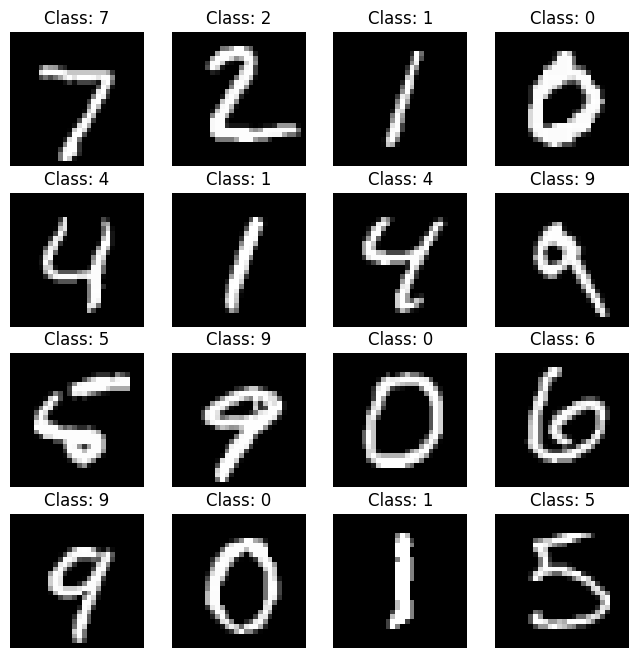

In [3]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Assuming mnist_dataloader contains your data loader

# Get the first batch of data
for images, classes in mnist_dataloader:
    # Visualize the first 16 images and their classes
    num_images = len(images)
    fig, axs = plt.subplots(4, 4, figsize=(8, 8))

    for i in range(num_images):
        row = i // 4
        col = i % 4

        # Convert the PyTorch tensor back to a PIL Image for visualization
        image = F.to_pil_image(images[i])
        
        axs[row, col].imshow(image, cmap='gray')
        axs[row, col].set_title(f'Class: {classes[i]}')
        axs[row, col].axis('off')

    plt.show()
    break  # Break after visualizing the first batch


You have used a built-in dataset and configured dataloader associated with the dataset. Next, you are going to implement several Dataset objects dedicated to medical images. 

### Part II - MRI Dataloader (simple)

In the first part of the laboratory you loaded the built-in MNIST dataset.

However, in practice, you usually have your own dataset. Independent whether the dataset is public or private, it requires a dedicated Dataset object to load the assosciated images/volumes/annotations.

To implement your own Dataset object you need to:
<ul>
  <li> Create your own class with the **tc.utils.data.Dataset** as the parent class.
  <li> Overload the **__init__** function responsible for defining the parameters assosciated with the given Dataset and initializing the logic used during loading.
  <li> Overload the **__len__** function defining the size of the Dataset (number of cases).
  <li> Overload the **__getitem__** function responsible for loading a single case within the dataset (images + additional metadata like labels or annotations).
</ul>

In the first part you are going to use the dataset containing magnetic resonance images of brain dedicated to the tumor classification.

Please download the dataset from:

https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri?resource=download

, and upload it to your Google Drive or directly to the Google Colaboratory **/content** folder.

If you plan to use the Google Drive (better option), you should:

On the left, under the **Files** bar, find a button called **Mount Drive** and choose your Google Drive.
It should appear in the **/content** folder as a **drive** or with different name if using non-default settings. Then you will need to unzip the dataset file to a selected path within your Google Drive.

In [4]:
input_file = None # Path to the "Brain_MRI.zip"
output_folder = None # Path to the folder where you would like to unzip the input ".zip" file

print(f"Input file path: {input_file}")
print(f"Output folder path: {output_folder}")

# !unzip {input_file} -d {output_folder} # Do this only once, them comment out this command

Input file path: None
Output folder path: None


Explore the unzipped data. You should see two folders inside the parent folder: **Training** and **Testing**. Inside these folders you will find four additional folders called: **pituitary_tumor**, **glioma**, **meningioma**, and **no_tumor**. All images inside these folder contain 2-D MRI slices presenting one of the classes.

Please note that the problem is simplfied - the cases are represented only by one 2-D slice from a 3-D MRI volume. In reality - the MRI imagaes are 3-D volumes containing hunderds of 2-D slices for each case.

The next task is to implement a dedicated Dataset object:

In [5]:
import torch as tc
import torchvision.transforms as transforms
import os
import SimpleITK as sitk
from PIL import Image
class BrainMRIDataset(tc.utils.data.Dataset):
    def __init__(self, dataset_path: str, mode: str = "training"):
        self.dataset_path = dataset_path
        self.mode = mode  # "training" or "testing"

        if self.mode == "training":
            self.data_path = os.path.join(self.dataset_path, "Training")
        elif self.mode == "testing":
            self.data_path = os.path.join(self.dataset_path, "Testing")
        else:
            raise ValueError("Unsupported mode.")

        self.classes = os.listdir(self.data_path)
        print(f"Available classes: {self.classes}")
        self.classes_dict = {self.classes[i]: i for i in range(len(self.classes))}
        print(f"Classes dict: {self.classes_dict}")

        # Creation of all training cases in the form of a list containing tuples with: (path_to_file, class_number)
        self.cases = []
        for i, current_class in enumerate(self.classes):
            current_class_path = os.path.join(self.data_path, current_class)
            for current_case in os.listdir(current_class_path):
                case_path = os.path.join(current_class_path, current_case)
                self.cases.append((case_path, i))  # (path_to_file, class_number)

        # Transformation to be applied to each image
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.cases)

    def __getitem__(self, idx):
        current_case = self.cases[idx]
        current_path, current_class = current_case

        # Read image using SimpleITK
        image = sitk.ReadImage(current_path)
        image_array = sitk.GetArrayFromImage(image)

        # Choose a representative slice (e.g., middle slice)
        middle_slice = image_array.shape[0] // 2
        current_image = Image.fromarray(image_array[middle_slice, :, :])

        # Apply transformations
        current_image = self.transform(current_image)

        return current_image, current_class


Now create the DataLoader responsible for loading cases from the Dataset. Notice that you do not have to make any changes with respect to the DataLoader - the interface is the same as long as the Dataset is implemented correctly.

In [6]:

dataset_path = './lab3_data'

# Create an instance of the BrainMRIDataset
amri_dataset = BrainMRIDataset(dataset_path, mode="training")

# Set parameters for DataLoader
batch_size = 16
shuffle = True

# Create the DataLoader
mri_dataloader = tc.utils.data.DataLoader(dataset=amri_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2)


Available classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Classes dict: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


Finally, verify whether the images are loaded correctly:

In [7]:
import matplotlib.pyplot as plt
import torchvision

# Assuming the batch size is 16
batch_size = 16

# Iterate through the dataloader
for images, classes in mri_dataloader:
    # Unnormalize the images before displaying (assuming normalization was applied)
    unnorm = torchvision.transforms.Normalize((-1,), (2,))
    unnorm_images = unnorm(images)

    # Create a grid of images
    img_grid = torchvision.utils.make_grid(unnorm_images, nrow=int(batch_size ** 0.5))

    # Transpose the image tensor to arrange channels properly for plotting
    img_grid = img_grid.permute(1, 2, 0)

    # Display the images
    plt.imshow(img_grid.squeeze(), cmap='gray')
    plt.title(f'Batch of MRI Images')
    plt.axis('off')
    plt.show()

    # Break after displaying the first batch
    break


In this part you implemented a basic dataloader dedicated to MRI images. However, in practice, it is better to make the Dataset object a bit more complicated. This is the task for the next part.

### Part III - MRI Dataloader (extended)

In practice implementing the whole logic in the **__init__** function (as in the example above) is impractical. Better idea is to propose a unified representation and seperate the logic for pairing images with classes or other metadata outside the Dataset object.

The reason for this is connected with the fact that there may be more datasets than one that you would like to use at the same time and split or combine them whenever necessary. This is difficult if the datasets were acquired in different institutions without standarization.

Therefore, now slightly modify the Dataset from the previous Part by using **pandas** library to create and split the input dataset. The **csv** file should contain two columns: relative input path and the corresponding class. This way, you can firstly preprocess different datasets to the same representation and then combine them or split using just the **csv** file.

Note: In practice, for larger dataset, instead of using **csv** files you use tools dedicated to databases.

First, parse the dataset into a csv representation:

In [ ]:
training_cases = []
testing_cases = []
training_csv_path = "./lab3_data/training.csv"
testing_csv_path = "./lab3_data/testing.csv"
# TODO - list all the available classes
classes = amri_dataset.classes
print(f"Available classes: {classes}")
classes_dict = amri_dataset.classes_dict
print(f"Classes dict: {classes_dict}")

# TODO - populate both the training and testing cases with the tuples
for current_class in classes:
    current_class_path = os.path.join(amri_dataset.data_path, current_class)
    
    # Training cases
    if amri_dataset.mode == "training":
        for current_case in os.listdir(current_class_path):
            case_path = os.path.join(current_class_path, current_case)
            training_cases.append((case_path, classes_dict[current_class], current_class))

    # Testing cases
    elif amri_dataset.mode == "testing":
        for current_case in os.listdir(current_class_path):
            case_path = os.path.join(current_class_path, current_case)
            testing_cases.append((case_path, classes_dict[current_class], current_class))

# TODO - create the dataframes and save them to .csv
training_df = pd.DataFrame(training_cases, columns=["image_path", "image_class_number", "image_class_name"])
testing_df = pd.DataFrame(testing_cases, columns=["image_path", "image_class_number", "image_class_name"])

# Save the dataframes to CSV files
training_df.to_csv(training_csv_path, index=False)
testing_df.to_csv(testing_csv_path, index=False)


Available classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Classes dict: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


Now modify the Dataset class to use **csv** files instead of implementing the logic inside the **init** function.

In [ ]:
class BrainMRIDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path: str, mode: str = "training", csv_file: str = None):
        self.dataset_path = dataset_path
        self.mode = mode  # "training" or "testing"
        self.csv_file = csv_file

        if self.csv_file is not None:
            # Load information from CSV file
            self.df = pd.read_csv(self.csv_file)
            self.classes = self.df["image_class_name"].unique()
            self.classes_dict = {cls: i for i, cls in enumerate(self.classes)}
            self.cases = list(zip(self.df["image_path"], self.df["image_class_number"]))
        else:
            if self.mode == "training":
                self.data_path = os.path.join(self.dataset_path, "Training")
            elif self.mode == "testing":
                self.data_path = os.path.join(self.dataset_path, "Testing")
            else:
                raise ValueError("Unsupported mode.")

            self.classes = os.listdir(self.data_path)  # Assumption that the classes are represented by the folder names
            print(f"Available classes: {self.classes}")
            self.classes_dict = {self.classes[i]: i for i in range(len(self.classes))}
            print(f"Classes dict: {self.classes_dict}")  # Mapping from the classes to numbers

            # Creation of all training cases in the form of a list containing tuples with: (path_to_file, class_number)
            self.cases = []
            for i, current_class in enumerate(self.classes):
                current_class_path = os.path.join(self.data_path, current_class)
                for current_case in os.listdir(current_class_path):
                    case_path = os.path.join(current_class_path, current_case)
                    self.cases.append((case_path, i))  # (path_to_file, class_number)

        # Transformation to be applied to each image
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resample the images to the same resolution (224x224)
            transforms.Grayscale(num_output_channels=1),  # Convert the images to grayscale if not already
            transforms.ToTensor(),  # Convert the image to a PyTorch tensor
            transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1] range
        ])

    def __len__(self):
        return len(self.cases)

    def __getitem__(self, idx):
        current_case = self.cases[idx]
        current_path, current_class = current_case

        # Read image using SimpleITK
        image = sitk.ReadImage(current_path)
        image_array = sitk.GetArrayFromImage(image)

        # Choose a representative slice (e.g., middle slice)
        middle_slice = image_array.shape[0] // 2
        current_image = Image.fromarray(image_array[middle_slice, :, :])

        # Apply transformations
        current_image = self.transform(current_image)

        return current_image, current_class


And now again verify whether everything works correctly by creating the DataLoader and showing an exemplary batch from the training dataset:

In [ ]:
# import torch
# from torch.utils.data import DataLoader
# import matplotlib.pyplot as plt

# # Create an instance of the BrainMRIDataset using CSV file
# amri_dataset_csv = BrainMRIDataset(dataset_path=None, mode="training", csv_file="./lab3_data/training.csv")

# # Set parameters for DataLoader
# batch_size = 16
# shuffle = True

# # Create the DataLoader
# mri_dataloader_csv = DataLoader(dataset=amri_dataset_csv, batch_size=batch_size, shuffle=shuffle, num_workers=2)

# # Verify DataLoader and show an exemplary batch
# for batch in mri_dataloader_csv:
#     images, labels = batch
#     print(f"Batch shape - Images: {images.shape}, Labels: {labels.shape}")

#     # Display the first image from the batch
#     plt.imshow(images[0][0].numpy(), cmap='gray')
#     plt.title(f"Class: {labels[0].item()}")
#     plt.show()

#     break  # Break after displaying the first batch for simplicity


You should be now familiar with implementing your own Datasets. The next part is for you to train - you are going to implement another one from scratch, without any additional guides.

### Part IV - Endoscopy Dataloader

In this part you are going to implement dataset dedicated to image segmentation (to be then used during Laboratory 6). 

The dataset is dedicated to the segmentation of surgical instruments from endoscopy images and comes from:

https://www.kaggle.com/datasets/debeshjha1/kvasirinstrument

We will use the dataset during Laboratory 6 because endoscopy images are relatively low resolution 2-D images than can be easily processed using Google Colaboratory. In reality they are video sequences, however, you are going to process just single frames.

Download the dataset and repeat the steps from the previous parts of the laboratory. Start with creating the dataset:

In [ ]:
# TODO - implement your own dataset object for the endoscopy images
# (together with preprocessing the dataset to the .csv files and unzipping the archive on Google Colab)

# TODO

Then create the dataloader:

In [ ]:
# TODO

And finally visualize the images with the corresponding segmentation masks:

In [ ]:
# TODO

### Conclusion

Congratulations, you have implemented several datasets dedicated to load medical images. You should be now able to implement you own dataset whenever necessary.

After the laboratory you should:
<ul>
  <li> Understand the difference between Dataset and Dataloader objects.
  <li> Implement your own Dataset object for a given medical dataset.
  <li> Use the Dataloader object with any Dataset to load the data using the desired hyperparameters.
  <li> Verify whether the Dataloader works and loads the data appropriately.
</ul>

During the next laboratory you are going to combine the knowledge from Laboratory 2 and Laboratory 3 to implement and train a simple convolutional neural network for medical image classification.